In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from collections import deque

# Threshhold Functions

These functions use the Sobel, Magnitude, and Direction gradients to identify lines in the original images. These three processes are combined in the fourth function to generate the thresholded Gradient image below. It is the basis for identifying lane lines in subsequent images.

In [2]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    grad_binary = sxbinary
    
    return grad_binary
   

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_factor = np.max(abs_sobel)/255 
    # 5) Create a binary mask where mag thresholds are met
    scaled_sobel = (abs_sobel/scaled_factor).astype(np.uint8) 
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary
    #binary_output = np.copy(img) # Remove this line
    mag_binary = binary_output
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary


def combined_generator(image):
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    #Try different combinations and see what you get. 

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

   

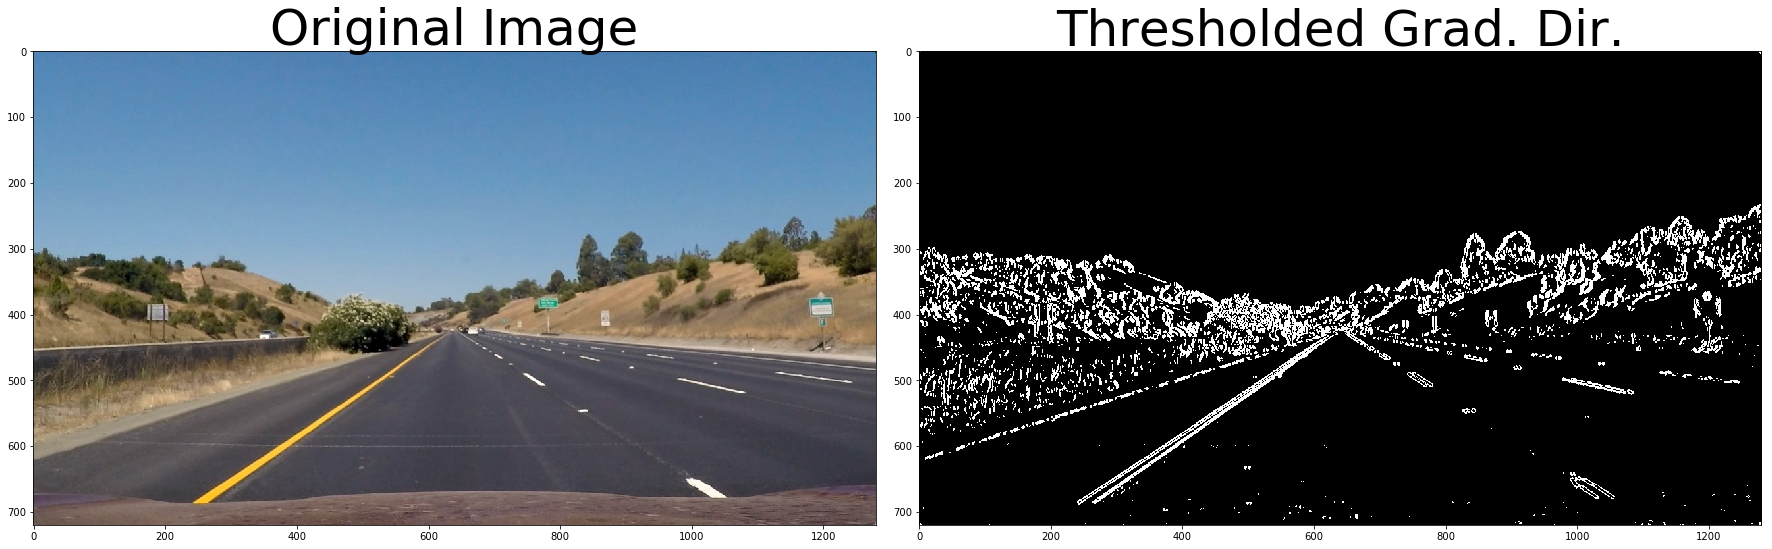

In [20]:

# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('test_images\straight_lines1.jpg')

combined = combined_generator(image)

# Plot the result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')

ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

#combined = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
#plt.imshow(combined, cmap='gray')
#plt.show()
#print("combined.dtype = ",combined.dtype)
#print("image.dtype = ",image.dtype)
    



# Color Threshold 

This function seperates the orignal image into Red, Green, and Blue components. In the end I did not include these in the final transform. They did not appear to improve the performance.

In [3]:
def hls_color_thresh(image, threshlow, threshhigh):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > threshlow) & (gray <= threshhigh)] = 1
    return binary



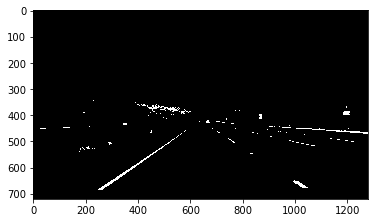

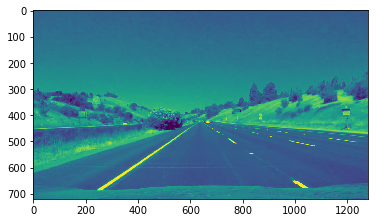

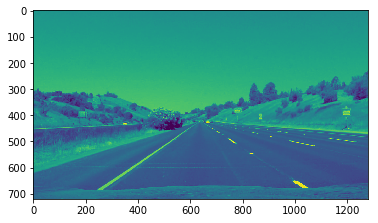

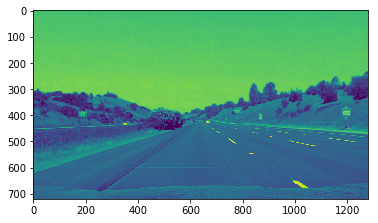

In [5]:
binary = hls_color_thresh(image, 180, 255)
plt.imshow(binary, cmap='gray')
plt.show()
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

plt.imshow(R)
plt.show()

plt.imshow(G)
plt.show()

plt.imshow(B)
plt.show()


# 1.Camera Calibration

To calibrate the camera I used cv2.findChessboardCorners. I read in all of the chessboard images using glob.glob (
a first for me). The images were converted to gray scale using cv2.cvtColor before being fed into the corners function.
This output was fed into cv2.CalibrateCamera which created the output mtx and dist which are used to adjust all subsequent images.


In [4]:

def calibrate_camera(nx, ny, calibration_images):
    # the following 3 lines are taken from the Python tutorial
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    img_points = [] #2d points 
    obj_points = [] #3d points in real world
    shape = (None, None)
    
    images = glob.glob(calibration_images)
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        #print("fname = ",fname)
        
        # Make a list of calibration images
        #fname = 'camera_cal\calibration1.jpg'
        #print("img.shape[0] = ",img.shape[0])
        #print("img.shape[1] = ",img.shape[1])
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #for writeup
            #plt.imshow(img) 
            #plt.show()
            img_points.append(corners)
            obj_points.append(objp)
             
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    return mtx, dist



In [7]:
#undist = cv2.undistort(img,mtx,dist, None, mtx)
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

print("mtx = ",mtx)
print("dist = ",dist)

mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


# 2. Correct Raw Images

All of the images used to find the lanes ultimately need to be undistorted. I fed the images into cv2.undist with the mtx, and dist from the camera calibrater. Two sample images are provided below. I find it difficult to notice the change in most images. The second image includes an overhead sign. In the original image the sign appears to be curved. In the undistored image it is straight a distinct difference.


In [5]:
def undistort(img, mtx, dist):
    
    return cv2.undistort(img, mtx, dist, None, mtx)



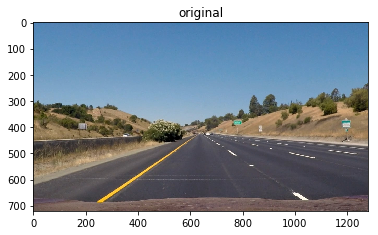

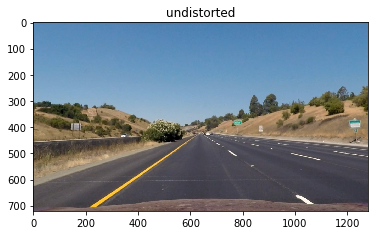

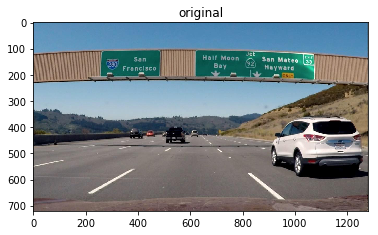

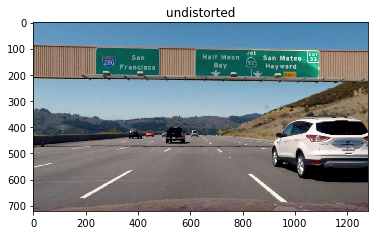

In [11]:
image = cv2.imread('test_images\straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

undist = undistort(image,mtx,dist)
plt.imshow(image),plt.title("original")  
plt.show()
plt.imshow(undist),plt.title("undistorted")   
plt.show()
#for unknown reasons files test1.jpg thru test6 could not be read until the names were changed. WTF.
#test1 = cv2.imread('test_images\Btest3.jpg')
#plt.imshow(test1) 
#plt.show()
#test1u= undistort(test1,mtx,dist)

#plt.imshow(test1u) 
#plt.show()
sign_image = mpimg.imread('signs_vehicles_xygrad.png')
sign_image_undist= undistort(sign_image,mtx,dist)
plt.imshow(sign_image),plt.title("original") 
plt.show()
plt.imshow(sign_image_undist),plt.title("undistorted")  
plt.show()

# 3. Perspective Transform

In order to easily do the math of conputing curves it is easiest to transform the image to an overhead. This is done below using cv2.PerspectiveTransform. A set of 4 corners of a rectangle are identified on the lane. The 4 original points are the defined in the first 4 lines in the function. The target 4 corners are the second group of for code lines. They are used to project and distort the entire image on to an overhead projection. Note the original image below and its warped version on the right.

In [6]:
def perspective_transform(img):
    leftupperpoint = [525,500]# formerly [500,500]
    rightupperpoint = [775,500]# formerly [760,500]
    leftlowerpoint = [210,700]# formerly [240,700]
    rightlowerpoint = [1080,700]# formerly [1080,700]
    d_leftupperpoint = [240,0]
    d_rightupperpoint = [1080,0]
    d_leftlowerpoint = [240,700]
    d_rightlowerpoint = [1080,700]
    src = np.float32([leftupperpoint,rightupperpoint,leftlowerpoint,rightlowerpoint])
    dst = np.float32([d_leftupperpoint,d_rightupperpoint,d_leftlowerpoint,d_rightlowerpoint])
    if (len(img.shape)>2):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #print("color ",gray.dtype)
    else:
        gray = img.astype(np.uint8)
        #print("gray " ,gray.dtype)
    img_size = (gray.shape[1], gray.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, Minv


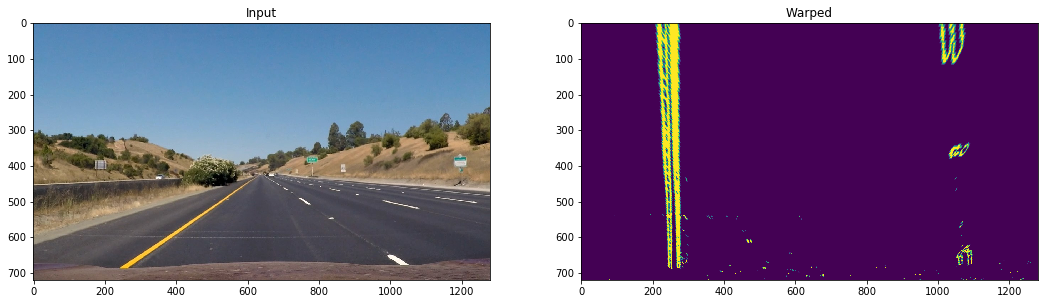

output.shape =  (720, 1280, 3)
output.dtype  uint8
warped.dtype  float64


In [13]:
    
output, M = perspective_transform(image)
warped, M2 = perspective_transform(combined)

#plt.figure(figsize=(20,20))
fig = plt.figure(figsize=(18,8))
plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(warped),plt.title('Warped')
plt.show()
print("output.shape = ",output.shape)


print("output.dtype ",output.dtype)
print("warped.dtype ",warped.dtype)

# Line Object

In [7]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], 6)
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

    def update_line(self, x, y, fitparam, xfit, curv, dist):
        self.detected = True
        self.allx = x
        self.ally = y
        self.current_fit = fitparam
        self.recent_xfitted.append(xfit)
        self.radius_of_curvature = curv
        self.line_base_pos = dist
        self.bestx = np.mean(self.recent_xfitted, axis=0)

# Finding Lane Curvature

   The first step was creating a histogram of the pixel distribution in the warped image. A left and right max is identified in the histogram using np.argmax. These are the left and right lanes, most of the time. A look at the challenge video output (challenge.mp4) illustrates some of the instances where the histogram is wrong. 
   A sliding window of 9 levels is created to follow the lane lines. Two arrays (left and right) are created to hold pixel positions of the two lanes in each of the 9 "windows". 
   This output if fed into fit_poly, fit_poly_m, and fit_poly_plot in turn. They use the functions np.polyfit and np.fillpoly to generate a curve and draw an area describing the curve.
   Lastly three functions draw the curve (project_lines), generate the radius of curvature (get_curve_m), and the distance of the car from center (dist2center_m).
   The output images can be seen below. I was suspicious of the radius of curvature output. It seemed far too big. However, that seems to be an "instantaneus" curvature that is large. Measurements in the video are more reasonable.

In [8]:

def locate_lanes(binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #plt.plot(histogram)
    #plt.show()
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print("nonzeroy = ", nonzeroy)
    #print("nonzerox = ", nonzerox)
    #print("nonzeroy.shape = ", nonzeroy.shape)
    #print("nonzerox.shape = ", nonzerox.shape)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    #print("leftx_base = ",leftx_base)
    #print("rightx_base = ",rightx_base)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        #print("win_y_low = ",win_y_low)
        #print("win_y_high = ",win_y_high)
        #print("win_xleft_low = ",win_xleft_low)
        #print("win_xleft_high = ",win_xleft_high)
        #print("win_xright_low = ",win_xright_low)
        #print("win_xright_high = ",win_xright_high)
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),
         #            (win_xleft_high,win_y_high),(0,255,0), 2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),
        #             (win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        #print("nonzeroy = ",nonzeroy )
        #print("nonzerox = ",nonzerox )
        #print("(nonzeroy >= win_y_low)  = ",(nonzeroy >= win_y_low) )
        #print("(nonzeroy < win_y_high)  = ",(nonzeroy < win_y_high) )
        #print("(nonzerox >= win_xleft_low)  = ", (nonzerox >= win_xleft_low))
        #print(" (nonzerox < win_xleft_high)  = ", (nonzerox < win_xleft_high) )
        good_left_inds = ((nonzeroy >= win_y_low) &
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        #print("good_left_inds.size = ",good_left_inds.size)
        #print("good_right_inds.size = ",good_right_inds.size)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #print("left_lane_inds = ",left_lane_inds)
        #print("right_lane_inds = ",right_lane_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        #print("left_lane_inds = ",len(left_lane_inds))
        #print("right_lane_inds = ",len(right_lane_inds))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    #print("left_lane_inds = ",left_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
   
    return leftx, lefty, rightx, righty

def locate_lanes_skip_window(binary_warped, left_fit, right_fit):
   
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox >
                       (left_fit[0]*(nonzeroy**2) +
                        left_fit[1]*nonzeroy +
                        left_fit[2] - margin)) &
                      (nonzerox <
                       (left_fit[0]*(nonzeroy**2) +
                        left_fit[1]*nonzeroy +
                        left_fit[2] + margin)))
    right_lane_inds = ((nonzerox >
                        (right_fit[0]*(nonzeroy**2) +
                         right_fit[1]*nonzeroy +
                         right_fit[2] - margin)) &
                       (nonzerox <
                        (right_fit[0]*(nonzeroy**2) +
                         right_fit[1]*nonzeroy +
                         right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty


def fit_poly(leftx, lefty, rightx, righty):
   
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def fit_poly_plot(
        binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty):
   
    margin = 100
    image_size = [1280,720]
    #below is new code suggested in review
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_c = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_c = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]
    width = right_c - left_c
    #print("width = ",width)
    xm_per_pix = 3.7 / width
    #print("xm_per_pix = ",xm_per_pix )
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array(
        [np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array(
        [np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result, ploty, left_fitx, right_fitx, xm_per_pix


def fit_poly_m(leftx, lefty, rightx, righty, xm_per_pix ):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 18/720 # meters per pixel in y dimension (after submission correction, formerly 30/720)
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    return left_fit, right_fit

def get_curv(binary_warped, left_fit, right_fit):
    
   
    y_eval = np.float32(binary_warped.shape[0] - 1)
   
    left_curverad = ((1 + (2*left_fit[0]*y_eval +
                    left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval +
                     right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad


def get_curv_m(binary_warped, left_fit, right_fit):
    
    y_eval = np.float32(binary_warped.shape[0] - 1)
    #print("y_eval = ",y_eval)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 18/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #ym_per_pix = 0
    #xm_per_pix = 0
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix +
                           left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix +
                            right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def dist2center_m(binary_warped, left_fit, right_fit,xm_per_pix):
    
    y_eval = np.float32(binary_warped.shape[0] - 1)
    # Define conversions in x and y from pixels space to meters
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    leftx = left_fit[0]*(y_eval)**2 + left_fit[1]*y_eval+ left_fit[2]
    rightx = right_fit[0]*(y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    center_px = binary_warped.shape[1] / 2.
    left_dist = (center_px - leftx) * xm_per_pix
    right_dist = (rightx - center_px) * xm_per_pix
    return left_dist, right_dist

def project_lines(undist, warped, Minv, ploty, left_fitx, right_fitx):
    
    #plt.imshow(undist),plt.title('undist')
    ##plt.imshow(warped),plt.title('warped')
    #plt.show()
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #plt.imshow(warp_zero),plt.title('warp_zero')
    #plt.show()
    #plt.imshow(color_warp),plt.title('color_warp')
    #plt.show()
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    #plt.imshow(newwarp),plt.title('newwarp')
    #plt.show()
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def validate_lane(left_curv, right_curv, left2c, right2c, left_fit, right_fit):
   
    # check curvature
    if left_curv >= 200 and right_curv >= 200:
        flag_curv = True
    else:
        flag_curv = False
    # check horizontal distance
    dist = left2c + right2c
    if dist >= 3. and dist <= 6.:
        flag_dist = True
    else:
        flag_dist = False
    # check parallel
    left_slope = left_fit[0]
    right_slope = right_fit[0]
    if np.absolute(right_slope - left_slope) <= 9e-4:
        flag_paral = True
    else:
        flag_paral = False
    return (flag_curv and flag_dist and flag_paral)


# Processing Image Code

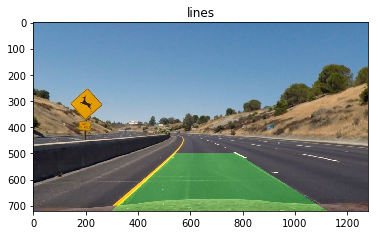

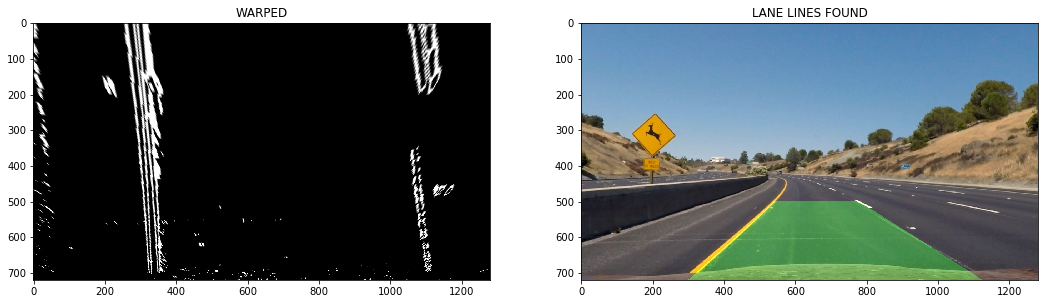

test4


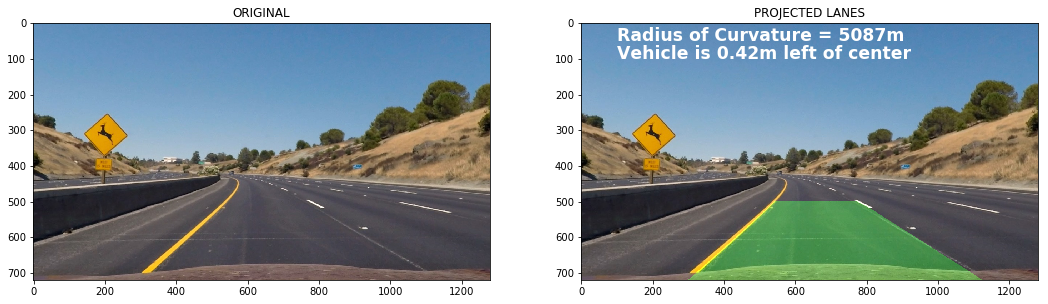

In [9]:
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

#xm_per_pix = 3.7/713 #initial default
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('test_images\straight_lines1.jpg')
image = mpimg.imread('test_images\Btest2.jpg')

plt.imshow(image),plt.title('image')

undist = undistort(image,mtx,dist)
combined = combined_generator(undist)
warped, M = perspective_transform(combined)


#images = glob.glob('test_images/test*.jpg')
#for fname in images:
    #img = cv2.imread(fname)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = helper.undistort(img, mtx, dist)
    #img,_ = helper.warp(img)
    #img = helper.combine_threds(img)
leftx, lefty, rightx, righty = locate_lanes(warped)
#print("leftx = ",leftx)
#print("leftx.shape = ",leftx.shape)
#print("lefty.shape = ",lefty.shape)
#print("rightx.shape = ",rightx.shape)
#print("righty.shape = ",righty.shape)
left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)

_, ploty, left_fitx, right_fitx, xm_per_pix = fit_poly_plot(warped, left_fit, right_fit, leftx, lefty, rightx, righty)
left_fit_m, right_fit_m = fit_poly_m(leftx, lefty, rightx, righty, xm_per_pix)
#print("left_fit = ",left_fit)
#print("left_fit_m = ",left_fit_m)


#print("test3")

lines = project_lines(undist, warped, M, ploty, left_fitx, right_fitx)
plt.imshow(lines),plt.title('lines')
plt.show()
fig = plt.figure(figsize=(18,8))
plt.subplot(121),plt.imshow(warped,'gray'),plt.title('WARPED')
plt.subplot(122),plt.imshow(lines),plt.title('LANE LINES FOUND')
plt.show()
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')


print("test4")
left_curverad, right_curverad = get_curv_m(warped, left_fit_m, right_fit_m)
curverad = (left_curverad + right_curverad) / 2
#print("left_curverad = ",left_curverad)
#print("right_curverad = ",right_curverad)
#print("curverad = ",curverad)
left2c, right2c = dist2center_m(warped, left_fit, right_fit,xm_per_pix)
if left2c < right2c: str_side = 'left'
else: str_side = 'right'
fig = plt.figure(figsize=(18,8))
font = {'family': 'sans-serif',
        'color':  'white',
        'weight': 'bold',
        'size': 'xx-large',
        }
plt.subplot(121),plt.imshow(undist),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(lines),plt.title('PROJECTED LANES')
plt.text(100, 50, 'Radius of Curvature = {:.0f}m'.format(curverad), fontdict=font)
plt.text(100, 100, 'Vehicle is {:.2f}m {:s} of center'.
            format(np.absolute((right2c-left2c)/2.), str_side), fontdict=font)
plt.show()

# Video Pipeline

This is just the still image process put into a reusable function. The output is included as test.mp4.

In [10]:
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

def process_image3(image,mtx, dist, left, right):

    undist = undistort(image,mtx,dist)
    combined = combined_generator(undist)
    warped, M = perspective_transform(combined)

    if left.detected and right.detected:
        
        left_x, left_y, right_x, right_y = locate_lanes_skip_window(
                image, left.current_fit, right.current_fit)
        left_fit, right_fit = fit_poly(left_x, left_y, right_x, right_y) 
        _, ploty, left_fitx, right_fitx, xm_per_pix = fit_poly_plot(warped, left_fit, right_fit, left_x, left_y,
                                                                    right_x, right_y)
        left_fit_m, right_fit_m = fit_poly_m(left_x, left_y, right_x, right_y, xm_per_pix)

        
        left_curverad, right_curverad = get_curv_m(warped, left_fit_m, right_fit_m) 
        left2c, right2c = dist2center_m(warped, left_fit, right_fit, xm_per_pix)
        
        if validate_lane(
            left_curverad, right_curverad, left2c, right2c, left_fit, right_fit):
            left.update_line(left_x, left_y, left_fit, left_fitx, left_curverad, left2c)
            right.update_line(right_x, right_y, right_fit, right_fitx, right_curverad, right2c)
        else:
            left.detected = False
            right.detected = False
            
    else:
            
        left_x, left_y, right_x, right_y = locate_lanes(warped) 
        left_fit, right_fit = fit_poly(left_x, left_y, right_x, right_y) 
        _, ploty, left_fitx, right_fitx, xm_per_pix = fit_poly_plot(warped, left_fit, right_fit, left_x, left_y,
                                                                    right_x, right_y)
        left_fit_m, right_fit_m = fit_poly_m(left_x, left_y, right_x, right_y, xm_per_pix)

        left_curverad, right_curverad = get_curv_m(warped, left_fit_m, right_fit_m) 
        left2c, right2c = dist2center_m(warped, left_fit, right_fit, xm_per_pix)
        
        
        
        if validate_lane(
            left_curverad, right_curverad, left2c, right2c, left_fit, right_fit):
            left.update_line(left_x, left_y, left_fit, left_fitx, left_curverad, left2c)
            right.update_line(right_x, right_y, right_fit, right_fitx, right_curverad, right2c)
        else:
            left.detected = False
            right.detected = False
            
            
            
    #result = project_lines(undist, warped, M, ploty, left_fitx, right_fitx) #old line
    result = project_lines(undist, warped, M, ploty, left.bestx, right.bestx)
    curverad = (left.radius_of_curvature + right.radius_of_curvature) / 2
    
    if left.line_base_pos < right.line_base_pos: str_side = 'left'
    else: str_side = 'right'
        
    dist2center = np.absolute((right.line_base_pos - left.line_base_pos) / 2.)
    cv2.putText(result,
                'Radius of Curvature = {:.0f}m'.format(curverad),
                (100, 50),
                fontFace=cv2.FONT_HERSHEY_PLAIN,
                fontScale = 4,
                color=(255,255,255),
                thickness=2,)
    cv2.putText(result,
                'Vehicle is {:.2f}m {:s} of center'.
                format(np.absolute((right2c-left2c)/2.), str_side),
                (100, 100),
                fontFace=cv2.FONT_HERSHEY_PLAIN,
                fontScale = 4,
                color=(255,255,255),
                thickness=2,)
    
    return result

# Processing Video

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image1(image):
    return process_image3(image, mtx, dist, left, right)

def flip(image):
    """Flips an image vertically """
    return image[::-1] # remember that image is a numpy array


#print("mtx = ", mtx)
#print("dist = ",dist)

left = Line()
right = Line()

video_output = 'test.mp4'
clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(process_image1)
#new_clip.write_videofile("my_new_clip", audio = False)
%time new_clip.write_videofile(video_output, audio = False)



[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████████████████████████████████▉| 1260/1261 [19:09<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 19min 9s


# Challenge Video (a.k.a. "Everybody Dies Now")

The challenge output is "not ready for prime time". It's output can be found at chanllenge.mp4.

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image1(image):
    return process_image3(image, mtx, dist, left, right)

def flip(image):
    """Flips an image vertically """
    return image[::-1] # remember that image is a numpy array


#print("mtx = ", mtx)
#print("dist = ",dist)

video_output = 'challenge.mp4'
clip = VideoFileClip("challenge_video.mp4")
new_clip = clip.fl_image(process_image1)
#new_clip.write_videofile("my_new_clip", audio = False)
%time new_clip.write_videofile(video_output, audio = False)


[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4



100%|████████████████████████████████████████| 485/485 [07:36<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 

Wall time: 7min 37s


# Discussion

   Many things confuse the algorithm. In the test video, it misdraws the lines on the bridges, but they are not catastrophic.  In the challenge video road repairs confuse the histogram. To fix this a range of accepted line widths would need to be added. Then only pavement lines that were similar in size to real lane lines would fool the algorithm.
   The two test videos were both filmed in the South Bay. Where I live in the North Bay the roads are far worse. Driving on I-80 between Berkeley and highway 4 is like a WW2 bombing run. The pot holes are the flack and little rocks kicked up are the shrapnel (I'm on my fourth windshield.) Half of the time there are either no painted lines or too many (old lines not removed when the road has been shifted a few feet left or right).  I find my way by following the cars in front of me. I'm currious to see how we address these problems in future projects.
   
   Post Review Addendum: After improving the sliding window and the width of the lane calculations the results improved significantly. Also, adding the validate_lane function fixed most problems. The lane is correctly identified on the bridges and the "paving line" at 44 seconds into the video no longer fools the algorithm. However, occasionally the plotted lane is miss drawn about a foot to the left or right. This is due to the "best guess" guessing wrong. But, that is comparable to a human driver. (I know we strive to do better than humans.)
   The challenge video is much better, but could still be improved. If I had more time, I'd throw more effort into this, but it is getting very late in the term and I still have to start on project 5.